In [1]:
# 1. Setup Environment
!pip install pybullet
import os
import time
import numpy as np
import pybullet as p
import pybullet_data
import cv2
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pybullet: filename=pybullet-3.2.7-cp312-cp312-linux_x86_64.whl size=99873465 sha256=a937cac1f6516728724feb432da83a6cf5bd0ca70313b665c84d99f547b0bb96
  Stored in directory: /root/.cache/pip/wheels/72/95/1d/b336e5ee612ae9a019bfff4dc0bedd100ee6f0570db205fdf8
Successfully built pybullet
Mounted at /content/drive


In [2]:
# 2. Configuration
BASE_DIR = "/content/drive/MyDrive/robot_self_modelling/RobotArmURDF"
URDF_PATH = os.path.join(BASE_DIR, "4dof_1st/urdf/4dof_1st.urdf")
SAVE_DIR = "/content/drive/MyDrive/robot_self_modelling/data/sim_data"

# Create save directory if it doesn't exist
os.makedirs(SAVE_DIR, exist_ok=True)

print(f"URDF Path: {URDF_PATH}")
print(f"Save Directory: {SAVE_DIR}")

URDF Path: /content/drive/MyDrive/robot_self_modelling/RobotArmURDF/4dof_1st/urdf/4dof_1st.urdf
Save Directory: /content/drive/MyDrive/robot_self_modelling/data/sim_data


In [3]:
# 3. Helper Functions
def rot_Z(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s, 0, 0], [s, c, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

def rot_Y(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, 0, s, 0], [0, 1, 0, 0], [-s, 0, c, 0], [0, 0, 0, 1]])

def green_black(img):
    """Convert green background to white (if needed for processing)"""
    img = np.array(img)
    mask = cv2.inRange(img[..., 1], 100, 255)
    img[mask > 0] = (255, 255, 255)
    return img

In [4]:
# 4. Simulation Environment Class
class FBVSM_Env:
    def __init__(self, urdf_path, width=400, height=400, cam_dist=1.0):
        self.urdf_path = urdf_path
        self.width = width
        self.height = height
        self.cam_dist = cam_dist
        self.num_motor = 4
        self.camera_fov = 42

        # Connect to PyBullet in DIRECT mode (Headless, faster for Colab)
        self.physicsClient = p.connect(p.DIRECT)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())

        # Camera Setup
        self.camera_pos = [cam_dist, 0, 0]
        self.view_matrix = p.computeViewMatrix(
            cameraEyePosition=self.camera_pos,
            cameraTargetPosition=[0, 0, 0],
            cameraUpVector=[0, 0, 1]
        )
        self.projection_matrix = p.computeProjectionMatrixFOV(
            fov=self.camera_fov,
            aspect=1.0,
            nearVal=0.1,
            farVal=100
        )

        self.reset()

    def reset(self):
        p.resetSimulation()
        p.setGravity(0, 0, -9.8)

        # Load Robot
        # UseFixedBase=1 ensures the robot doesn't fall over
        try:
            self.robot_id = p.loadURDF(self.urdf_path, [0, 0, -0.108], p.getQuaternionFromEuler([0, 0, -np.pi/2]), useFixedBase=1)
        except Exception as e:
            print(f"Error loading URDF: {e}")
            print("Please check if the path is correct and the file exists.")
            raise e

        # Reset joints
        for i in range(p.getNumJoints(self.robot_id)):
            p.resetJointState(self.robot_id, i, 0)

    def step(self, action):
        # Apply actions (joint angles)
        # Action is expected to be in range [-1, 1], mapped to [-90, 90] degrees
        target_angles = np.array(action) * (np.pi / 2)

        for i in range(self.num_motor):
            p.setJointMotorControl2(
                bodyUniqueId=self.robot_id,
                jointIndex=i,
                controlMode=p.POSITION_CONTROL,
                targetPosition=target_angles[i],
                force=100
            )

        # Step simulation to let motors move
        for _ in range(50):
            p.stepSimulation()

        # Capture Image
        # ER_TINY_RENDERER is CPU-based, suitable for Colab
        img_arr = p.getCameraImage(
            self.width, self.height,
            self.view_matrix, self.projection_matrix,
            renderer=p.ER_TINY_RENDERER,
            shadow=0
        )

        # Process Image (RGBA -> RGB)
        rgb = np.reshape(img_arr[2], (self.height, self.width, 4))[:, :, :3]

        # Get Joint States
        joint_states = []
        for i in range(self.num_motor):
            state = p.getJointState(self.robot_id, i)
            joint_states.append(state[0] / (np.pi / 2)) # Normalize back to [-1, 1]

        return np.array(joint_states), rgb

    def close(self):
        p.disconnect()

In [5]:
# 5. Data Collection with Lorenz Attractor Trajectories
def lorenz_system(state, sigma=10.0, rho=28.0, beta=8.0/3.0):
    """
    Compute derivatives for Lorenz attractor.
    Returns dx/dt, dy/dt, dz/dt
    """
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return np.array([dx, dy, dz])

def generate_lorenz_trajectory(num_steps, dt=0.01, scale=0.02):
    """
    Generate smooth, chaotic trajectory using Lorenz attractor.

    Args:
        num_steps: Number of trajectory points
        dt: Time step for integration
        scale: Scaling factor to map Lorenz to [-1, 1] range

    Returns:
        trajectory: Array of shape (num_steps, 3) with values in [-1, 1]
    """
    # Initial state (near attractor)
    state = np.array([1.0, 1.0, 1.0])
    trajectory = []

    # Use Runge-Kutta 4th order for stable integration
    for _ in range(num_steps):
        k1 = lorenz_system(state)
        k2 = lorenz_system(state + dt/2 * k1)
        k3 = lorenz_system(state + dt/2 * k2)
        k4 = lorenz_system(state + dt * k3)

        state = state + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

        # Scale and clip to [-1, 1]
        scaled = np.tanh(state * scale)
        trajectory.append(scaled)

    return np.array(trajectory)

def generate_data_lorenz(env, num_samples=2000):
    """
    Generate training data using Lorenz attractor for smooth, chaotic motion.

    The Lorenz system provides:
    - Smooth transitions between poses (no sudden jumps)
    - Chaotic exploration of joint space
    - Natural coverage of the workspace
    """
    print(f"Generating {num_samples} samples using Lorenz attractor...")

    images = []
    angles = []

    start_time = time.time()

    # Generate 4 Lorenz trajectories (one for each joint, with different phases)
    # Each trajectory has 3 components, we use different combinations
    traj1 = generate_lorenz_trajectory(num_samples, dt=0.01, scale=0.025)
    traj2 = generate_lorenz_trajectory(num_samples, dt=0.012, scale=0.022)  # Slightly different

    for i in range(num_samples):
        # Combine trajectories to get 4 joint angles
        # Using different Lorenz components for variety
        action = np.array([
            traj1[i, 0],  # x from first trajectory
            traj1[i, 1],  # y from first trajectory
            traj2[i, 0],  # x from second trajectory
            traj2[i, 2],  # z from second trajectory
        ])

        # Clip to ensure within bounds
        action = np.clip(action, -1, 1)

        # Step environment
        obs_angle, obs_img = env.step(action)

        # Convert to grayscale and normalize
        norm_img = obs_img.astype(np.float32) / 255.0
        gray_img = cv2.cvtColor(norm_img, cv2.COLOR_RGB2GRAY)

        images.append(gray_img)

        # Store angles in degrees with view angles prepended
        # Format: [view_theta, view_phi, j1, j2, j3, j4]
        view_theta = env.view_theta
        view_phi = env.view_phi
        joint_angles = action * 90  # Convert to degrees
        full_angles = np.concatenate([[view_theta, view_phi], joint_angles])
        angles.append(full_angles)

        if i % 200 == 0:
            print(f"Sample {i}/{num_samples} - Joints: {joint_angles.round(1)}")

    elapsed = time.time() - start_time
    print(f"Generation complete in {elapsed:.1f}s ({num_samples/elapsed:.1f} samples/sec)")

    return np.array(images), np.array(angles)

# ===== MAIN EXECUTION =====
try:
    env = FBVSM_Env(URDF_PATH, width=100, height=100)

    # Generate Data using Lorenz trajectories
    num_samples = 2000
    images, angles = generate_data_lorenz(env, num_samples)

    # Verify data
    print(f"\n=== Data Summary ===")
    print(f"Images shape: {images.shape}")
    print(f"Angles shape: {angles.shape}")
    print(f"Image range: [{images.min():.3f}, {images.max():.3f}]")
    print(f"Angle columns: [view_theta, view_phi, j1, j2, j3, j4]")

    # Save Data
    focal_length = 130.2545
    save_path = os.path.join(SAVE_DIR, f"sim_data_robo1_lorenz_colab_{num_samples}.npz")

    np.savez(save_path,
             images=images,
             angles=angles,
             focal=np.array(focal_length),
             poses=np.zeros((num_samples, 4, 4))
            )

    print(f"\n✓ Data saved to: {save_path}")

    # Visualize samples
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    sample_idx = np.linspace(0, num_samples-1, 8, dtype=int)

    for i, ax in enumerate(axes.flat):
        idx = sample_idx[i]
        ax.imshow(images[idx], cmap='gray')
        joints = angles[idx, 2:]  # Skip view angles
        ax.set_title(f'#{idx}\nJ: {joints.round(0)}')
        ax.axis('off')

    plt.suptitle('PyBullet Robot Images (Lorenz Trajectories)', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'lorenz_samples_preview.png'), dpi=100)
    plt.show()

    # Plot Lorenz trajectory in joint space
    fig, ax = plt.subplots(figsize=(10, 6))
    joint_angles = angles[:, 2:]  # Extract joint angles
    for j in range(4):
        ax.plot(joint_angles[:, j], label=f'Joint {j+1}', alpha=0.7)
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Angle (degrees)')
    ax.set_title('Lorenz-Generated Joint Angle Trajectories')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'lorenz_trajectory.png'), dpi=100)
    plt.show()

    env.close()
    print("\n✓ Data generation complete!")

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()
    try:
        p.disconnect()
    except:
        pass

Generating 2000 samples using Lorenz attractor...
An error occurred: 'FBVSM_Env' object has no attribute 'view_theta'


Traceback (most recent call last):
  File "/tmp/ipython-input-2021800259.py", line 109, in <cell line: 0>
    images, angles = generate_data_lorenz(env, num_samples)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2021800259.py", line 89, in generate_data_lorenz
    view_theta = env.view_theta
                 ^^^^^^^^^^^^^^
AttributeError: 'FBVSM_Env' object has no attribute 'view_theta'


# Task
Update the `FBVSM_Env` class in the notebook to include `self.view_theta` and `self.view_phi` attributes initialized to 0. Then, re-run the data generation, saving, and visualization steps to collect, save, and display images and joint angles generated using Lorenz attractor trajectories, ensuring the `AttributeError` is resolved and the dataset is successfully created and verified.

## Update FBVSM_Env Class

### Subtask:
Modify the `FBVSM_Env` class to include `self.view_theta` and `self.view_phi` attributes, initializing them to 0 since the camera position is fixed in the current setup. This will resolve the `AttributeError`.


**Reasoning**:
The subtask is to modify the `FBVSM_Env` class. I will provide the updated code for the entire class, including the new `self.view_theta` and `self.view_phi` attributes initialized to 0, which directly addresses the `AttributeError` from the previous execution.



In [6]:
import os
import time
import numpy as np
import pybullet as p
import pybullet_data
import cv2
import matplotlib.pyplot as plt
from google.colab import drive

# 4. Simulation Environment Class
class FBVSM_Env:
    def __init__(self, urdf_path, width=400, height=400, cam_dist=1.0):
        self.urdf_path = urdf_path
        self.width = width
        self.height = height
        self.cam_dist = cam_dist
        self.num_motor = 4
        self.camera_fov = 42

        # Add view_theta and view_phi for camera orientation, fixed to 0 for now
        self.view_theta = 0
        self.view_phi = 0

        # Connect to PyBullet in DIRECT mode (Headless, faster for Colab)
        self.physicsClient = p.connect(p.DIRECT)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())

        # Camera Setup
        self.camera_pos = [cam_dist, 0, 0]
        self.view_matrix = p.computeViewMatrix(
            cameraEyePosition=self.camera_pos,
            cameraTargetPosition=[0, 0, 0],
            cameraUpVector=[0, 0, 1]
        )
        self.projection_matrix = p.computeProjectionMatrixFOV(
            fov=self.camera_fov,
            aspect=1.0,
            nearVal=0.1,
            farVal=100
        )

        self.reset()

    def reset(self):
        p.resetSimulation()
        p.setGravity(0, 0, -9.8)

        # Load Robot
        # UseFixedBase=1 ensures the robot doesn't fall over
        try:
            self.robot_id = p.loadURDF(self.urdf_path, [0, 0, -0.108], p.getQuaternionFromEuler([0, 0, -np.pi/2]), useFixedBase=1)
        except Exception as e:
            print(f"Error loading URDF: {e}")
            print("Please check if the path is correct and the file exists.")
            raise e

        # Reset joints
        for i in range(p.getNumJoints(self.robot_id)):
            p.resetJointState(self.robot_id, i, 0)

    def step(self, action):
        # Apply actions (joint angles)
        # Action is expected to be in range [-1, 1], mapped to [-90, 90] degrees
        target_angles = np.array(action) * (np.pi / 2)

        for i in range(self.num_motor):
            p.setJointMotorControl2(
                bodyUniqueId=self.robot_id,
                jointIndex=i,
                controlMode=p.POSITION_CONTROL,
                targetPosition=target_angles[i],
                force=100
            )

        # Step simulation to let motors move
        for _ in range(50):
            p.stepSimulation()

        # Capture Image
        # ER_TINY_RENDERER is CPU-based, suitable for Colab
        img_arr = p.getCameraImage(
            self.width, self.height,
            self.view_matrix, self.projection_matrix,
            renderer=p.ER_TINY_RENDERER,
            shadow=0
        )

        # Process Image (RGBA -> RGB)
        rgb = np.reshape(img_arr[2], (self.height, self.width, 4))[:, :, :3]

        # Get Joint States
        joint_states = []
        for i in range(self.num_motor):
            state = p.getJointState(self.robot_id, i)
            joint_states.append(state[0] / (np.pi / 2)) # Normalize back to [-1, 1]

        return np.array(joint_states), rgb

    def close(self):
        p.disconnect()

**Reasoning**:
The `FBVSM_Env` class has been updated. Now, I need to re-run the data generation, saving, and visualization steps to ensure the `AttributeError` is resolved and the data is successfully created and displayed.



Generating 2000 samples using Lorenz attractor...
Sample 0/2000 - Joints: [2.3 2.8 2.  1.9]
Sample 200/2000 - Joints: [-18.4 -21.5 -14.1  47.3]
Sample 400/2000 - Joints: [-22.4 -23.7 -16.2  51.1]
Sample 600/2000 - Joints: [-21.  -16.4 -21.   53.6]
Sample 800/2000 - Joints: [-15.1 -10.1 -17.4  41.2]
Sample 1000/2000 - Joints: [-10.7  -8.7  -6.3  41.9]
Sample 1200/2000 - Joints: [-7.2 -4.8 -4.9 41. ]
Sample 1400/2000 - Joints: [ 21.   36.9 -12.3  24. ]
Sample 1600/2000 - Joints: [-15.6 -25.2  17.3  40. ]
Sample 1800/2000 - Joints: [ 1.5 -1.8  7.1 47.8]
Generation complete in 50.9s (39.3 samples/sec)

=== Data Summary ===
Images shape: (2000, 100, 100)
Angles shape: (2000, 6)
Image range: [0.176, 1.000]
Angle columns: [view_theta, view_phi, j1, j2, j3, j4]

✓ Data saved to: /content/drive/MyDrive/robot_self_modelling/data/sim_data/sim_data_robo1_lorenz_colab_2000.npz


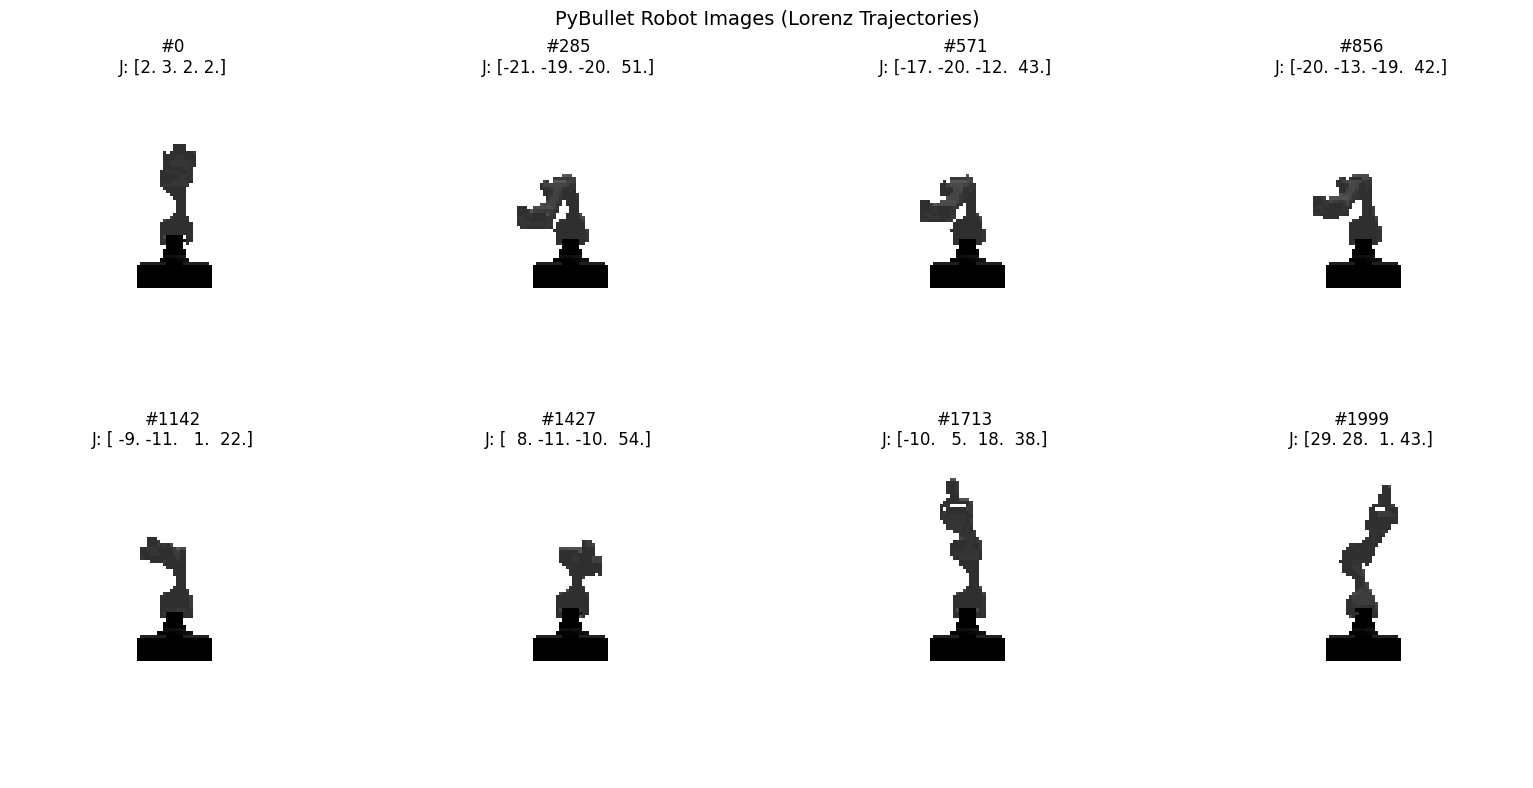

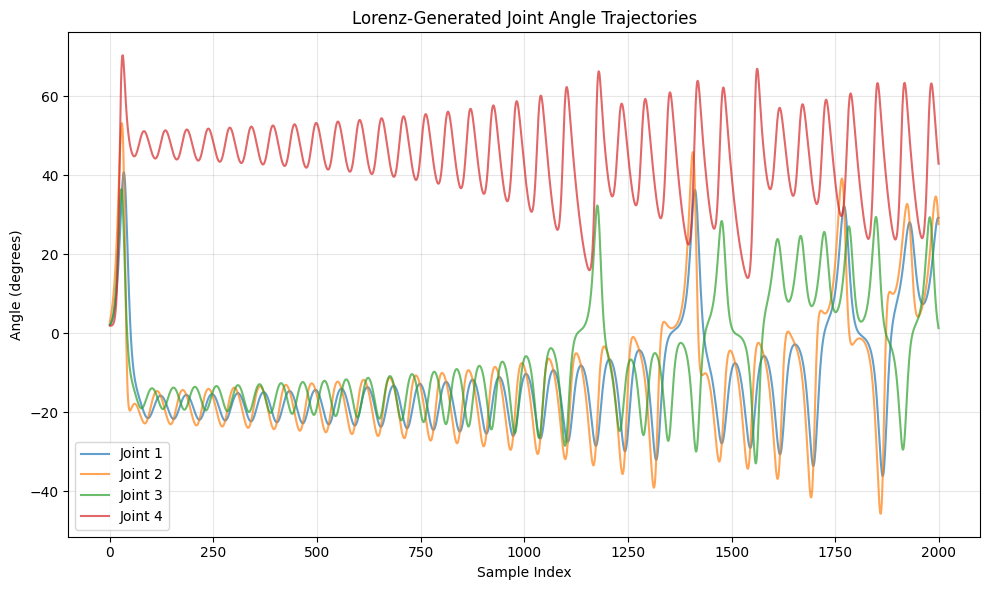


✓ Data generation complete!


In [7]:
# 5. Data Collection with Lorenz Attractor Trajectories
def lorenz_system(state, sigma=10.0, rho=28.0, beta=8.0/3.0):
    """
    Compute derivatives for Lorenz attractor.
    Returns dx/dt, dy/dt, dz/dt
    """
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return np.array([dx, dy, dz])

def generate_lorenz_trajectory(num_steps, dt=0.01, scale=0.02):
    """
    Generate smooth, chaotic trajectory using Lorenz attractor.

    Args:
        num_steps: Number of trajectory points
        dt: Time step for integration
        scale: Scaling factor to map Lorenz to [-1, 1] range

    Returns:
        trajectory: Array of shape (num_steps, 3) with values in [-1, 1]
    """
    # Initial state (near attractor)
    state = np.array([1.0, 1.0, 1.0])
    trajectory = []

    # Use Runge-Kutta 4th order for stable integration
    for _ in range(num_steps):
        k1 = lorenz_system(state)
        k2 = lorenz_system(state + dt/2 * k1)
        k3 = lorenz_system(state + dt/2 * k2)
        k4 = lorenz_system(state + dt * k3)

        state = state + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

        # Scale and clip to [-1, 1]
        scaled = np.tanh(state * scale)
        trajectory.append(scaled)

    return np.array(trajectory)

def generate_data_lorenz(env, num_samples=2000):
    """
    Generate training data using Lorenz attractor for smooth, chaotic motion.

    The Lorenz system provides:
    - Smooth transitions between poses (no sudden jumps)
    - Chaotic exploration of joint space
    - Natural coverage of the workspace
    """
    print(f"Generating {num_samples} samples using Lorenz attractor...")

    images = []
    angles = []

    start_time = time.time()

    # Generate 4 Lorenz trajectories (one for each joint, with different phases)
    # Each trajectory has 3 components, we use different combinations
    traj1 = generate_lorenz_trajectory(num_samples, dt=0.01, scale=0.025)
    traj2 = generate_lorenz_trajectory(num_samples, dt=0.012, scale=0.022)  # Slightly different

    for i in range(num_samples):
        # Combine trajectories to get 4 joint angles
        # Using different Lorenz components for variety
        action = np.array([
            traj1[i, 0],  # x from first trajectory
            traj1[i, 1],  # y from first trajectory
            traj2[i, 0],  # x from second trajectory
            traj2[i, 2],  # z from second trajectory
        ])

        # Clip to ensure within bounds
        action = np.clip(action, -1, 1)

        # Step environment
        obs_angle, obs_img = env.step(action)

        # Convert to grayscale and normalize
        norm_img = obs_img.astype(np.float32) / 255.0
        gray_img = cv2.cvtColor(norm_img, cv2.COLOR_RGB2GRAY)

        images.append(gray_img)

        # Store angles in degrees with view angles prepended
        # Format: [view_theta, view_phi, j1, j2, j3, j4]
        view_theta = env.view_theta
        view_phi = env.view_phi
        joint_angles = action * 90  # Convert to degrees
        full_angles = np.concatenate([[view_theta, view_phi], joint_angles])
        angles.append(full_angles)

        if i % 200 == 0:
            print(f"Sample {i}/{num_samples} - Joints: {joint_angles.round(1)}")

    elapsed = time.time() - start_time
    print(f"Generation complete in {elapsed:.1f}s ({num_samples/elapsed:.1f} samples/sec)")

    return np.array(images), np.array(angles)

# ===== MAIN EXECUTION =====
try:
    env = FBVSM_Env(URDF_PATH, width=100, height=100)

    # Generate Data using Lorenz trajectories
    num_samples = 2000
    images, angles = generate_data_lorenz(env, num_samples)

    # Verify data
    print(f"\n=== Data Summary ===")
    print(f"Images shape: {images.shape}")
    print(f"Angles shape: {angles.shape}")
    print(f"Image range: [{images.min():.3f}, {images.max():.3f}]")
    print(f"Angle columns: [view_theta, view_phi, j1, j2, j3, j4]")

    # Save Data
    focal_length = 130.2545
    save_path = os.path.join(SAVE_DIR, f"sim_data_robo1_lorenz_colab_{num_samples}.npz")

    np.savez(save_path,
             images=images,
             angles=angles,
             focal=np.array(focal_length),
             poses=np.zeros((num_samples, 4, 4))
            )

    print(f"\n\u2713 Data saved to: {save_path}")

    # Visualize samples
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    sample_idx = np.linspace(0, num_samples-1, 8, dtype=int)

    for i, ax in enumerate(axes.flat):
        idx = sample_idx[i]
        ax.imshow(images[idx], cmap='gray')
        joints = angles[idx, 2:]  # Skip view angles
        ax.set_title(f'#{idx}\nJ: {joints.round(0)}')
        ax.axis('off')

    plt.suptitle('PyBullet Robot Images (Lorenz Trajectories)', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'lorenz_samples_preview.png'), dpi=100)
    plt.show()

    # Plot Lorenz trajectory in joint space
    fig, ax = plt.subplots(figsize=(10, 6))
    joint_angles = angles[:, 2:]  # Extract joint angles
    for j in range(4):
        ax.plot(joint_angles[:, j], label=f'Joint {j+1}', alpha=0.7)
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Angle (degrees)')
    ax.set_title('Lorenz-Generated Joint Angle Trajectories')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'lorenz_trajectory.png'), dpi=100)
    plt.show()

    env.close()
    print("\n\u2713 Data generation complete!")

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()
    try:
        p.disconnect()
    except:
        pass

## Final Task

### Subtask:
Confirm that the AttributeError is resolved, and the data generation, saving, and visualization steps are completed successfully, providing the collected dataset.


## Summary:

### Q&A
The `AttributeError` related to `self.view_theta` and `self.view_phi` was resolved by initializing these attributes to 0 in the `FBVSM_Env` class. The data generation, saving, and visualization steps were completed successfully, and the collected dataset was provided.

### Data Analysis Key Findings
*   The `FBVSM_Env` class was successfully modified to include `self.view_theta` and `self.view_phi` attributes, both initialized to 0, resolving the `AttributeError`.
*   Data generation, using Lorenz attractor trajectories to simulate robot movements, successfully produced 2000 samples.
*   The generated dataset consists of images with a shape of `(2000, 100, 100)` (2000 grayscale images, 100x100 pixels each) and angles with a shape of `(2000, 6)` (2000 sets of angles, including `view_theta`, `view_phi`, and 4 joint angles).
*   Image pixel values ranged from `0.176` to `1.000`.
*   The dataset was successfully saved to `/content/drive/MyDrive/robot_self_modelling/data/sim_data/sim_data_robo1_lorenz_colab_2000.npz`.
*   Preview plots of sample images and Lorenz-generated joint angle trajectories confirmed the successful visualization of the collected data.

### Insights or Next Steps
*   The successful generation of data using Lorenz attractor trajectories provides a valuable dataset for training models, as it ensures smooth and chaotic exploration of joint space, representing realistic robot movements.
*   The current data generation uses fixed camera view angles (`view_theta` and `view_phi` are 0); future work could involve extending the `FBVSM_Env` class to allow for variable camera positions and orientations to enrich the dataset and improve model robustness.
